# library

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix 
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay

# Data Prepraration

In [15]:
stock_name = 'AAPL'
if os.path.exists('%s_20170601-20220601.csv'%stock_name):
    aapl = pd.read_csv('%s_20170601-20220601.csv'%stock_name, index_col=0) # if local data exists, read the data
else:
    aapl = yf.download(stock_name, start="2017-06-01", end="2022-06-01") # if no local data, download from yahoo finance
    aapl.to_csv('AAPL_20170601-20220601.csv') # save the data to local (for reproductivity)

In [16]:
# Features
aapl['O-C'] = aapl['Open'] - aapl['Close']
aapl['H-L'] = aapl['High'] - aapl['Low']
aapl['Sign'] = (aapl['Adj Close'] - aapl['Adj Close'].shift(1)).ge(0).astype(int)
aapl['Past Returns t-1'] = aapl['Adj Close'].shift(1) # t-1
aapl['Past Returns t-2'] = aapl['Adj Close'].shift(2) # t-2
aapl['Past Returns t-3'] = aapl['Adj Close'].shift(3) # t-3
aapl['Momentum'] = aapl['Adj Close'] - aapl['Adj Close'].shift(3) # k = 3
aapl['Moving Average'] = aapl.loc[:,['Past Returns t-%d'% i for i in [1,2,3]]].mean(axis=1) # n = 3

# as t-3 series is considered, the first 3 rows contains NA so that they are supposed to be drop
aapl = aapl.iloc[3:] 

In [17]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Sign,Past Returns t-1,Past Returns t-2,Past Returns t-3,Momentum,Moving Average
Date,,,,,,,,,,,,,,
2017-06-06,38.474998,38.952499,38.445000,38.612499,36.553143,106499600,-0.137501,0.5075,1,36.430077,36.789806,36.252579,0.300564,36.490821
2017-06-07,38.755001,38.994999,38.619999,38.842499,36.770878,84278400,-0.087498,0.3750,1,36.553143,36.430077,36.789806,-0.018929,36.591009
2017-06-08,38.812500,38.884998,38.599998,38.747501,36.680946,85003200,0.064999,0.2850,0,36.770878,36.553143,36.430077,0.250870,36.584699
2017-06-09,38.797501,38.797501,36.505001,37.244999,35.258587,259530800,1.552502,2.2925,0,36.680946,36.770878,36.553143,-1.294556,36.668322
2017-06-12,36.435001,36.522499,35.627499,36.355000,34.416046,289229200,0.080002,0.8950,0,35.258587,36.680946,36.770878,-2.354832,36.236804


In [18]:
# the first 80% data is used to training and the last 20% is for testing
train, test = train_test_split(
    aapl,
    test_size=0.5,
    random_state=2022, # for reproductivity
)
tr_x, tr_y = train.drop('Sign', axis = 1), train['Sign']
test_x, test_y = test.drop('Sign', axis = 1), test['Sign']

# Questions

## Question 2

* Make a decision about StandardScaler and the regressor vs classifier version of SVM

As is required, the sign of trend is our target, which is binary. For convenience, we choose the SVM classifier to predict the response variable.

The below result shows that the classification report for without/with standard scaling, respectively. As is shown, the accuracy of the model with standard scaling is less than the corresponding accuracy without standard scaling.

To sum up, the classifier without standard scaled data performs better.

In [34]:
def getSvmResults(input_dims,  X_tr, y_tr, X_test, y_test):
    # Scale
    X = X_tr.iloc[:, input_dims]
    print('Columns : ', X.columns.tolist())
    scaler = StandardScaler()
    scaled_tr_x = scaler.fit_transform(X)
    scaled_test_x = scaler.transform(X_test.iloc[:, input_dims]) 

    # non-standardScale
    model1 = SVC(C=1, kernel='linear', random_state=2022, probability=True)
    model1.fit(X, y_tr) 
    pred1 = model1.predict(X_test.iloc[:, input_dims])
    print('Without StandardScale')
    print(classification_report(y_test, pred1))

    # standardScale
    model2 = SVC(C=1, kernel='linear', random_state=2022, probability=True)
    model2.fit(scaled_tr_x, y_tr)
    pred2 = model2.predict(scaled_test_x)
    print('StandardScale')
    print(classification_report(y_test, pred2))
    return (model1, model2) , (scaled_tr_x, scaled_test_x), (pred1, pred2)


# Type I - 1.1. only use O-C, H-L features
OCHL_models, OCHL_scaled_x, OCHL_preds = getSvmResults([6,7], tr_x, tr_y, test_x, test_y) 
# Type I - 1.2. only use Past Returns t-1, Momentum features
past_models, past_scaled_x, past_preds = getSvmResults([8, 11], tr_x, tr_y, test_x, test_y) 
# Type I - 1.3. only use Close, Moving Average features
MMA_models, MMA_scaled_x, MMA_preds = getSvmResults([3, 12], tr_x, tr_y, test_x, test_y)  


Columns :  ['O-C', 'H-L']
Without StandardScale
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       289
           1       0.82      0.86      0.84       339

    accuracy                           0.82       628
   macro avg       0.82      0.82      0.82       628
weighted avg       0.82      0.82      0.82       628

StandardScale
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       289
           1       0.82      0.86      0.84       339

    accuracy                           0.82       628
   macro avg       0.82      0.82      0.82       628
weighted avg       0.82      0.82      0.82       628

Columns :  ['Past Returns t-1', 'Momentum']
Without StandardScale
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       289
           1       0.65      0.83      0.73       339

    accuracy                           0.67       628


# plot

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


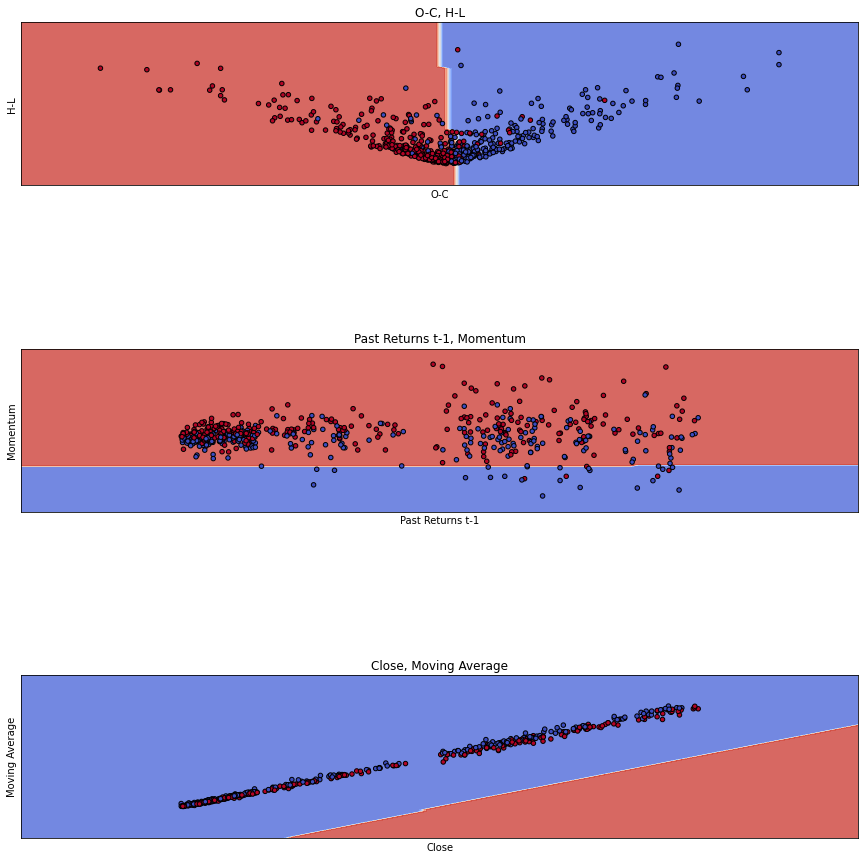

In [29]:
# title for the plots
title = "SVC with linear kernel"

# Only plot the models with standard scaled data
Xs = (OCHL_scaled_x[0], past_scaled_x[0], MMA_scaled_x[0])
models = (OCHL_models[0], past_models[0], MMA_models[0])
columns = ( tr_x.iloc[:, dims].columns.tolist() for dims in [[6,7], [8,11], [3,12]] )

# titles
titles = ('O-C, H-L', 'Past Returns t-1, Momentum', 'Close, Moving Average')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(3, 1, figsize=(15,15))
plt.subplots_adjust(wspace=0.4, hspace=1)

for clf, title, ax, X, colname in zip(models, titles, sub.flatten(), Xs, columns):
    X0, X1 = X[:, 0], X[:, 1]
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=colname[0],
        ylabel=colname[1],
    )
    ax.scatter(X0, X1, c=tr_y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

* ROC curve and confusion matrix

In [48]:
# Type I - 1.1. only use O-C, H-L features
def getRocAndCm(test_y, test_x, clf):
    pred_y = clf.predict(test_x)
    probs = clf.predict_proba(test_x)
    colnames = test_x.columns.tolist()
    print(colnames)

    # ROC
    roc = roc_auc_score(test_y, pred_y)
    print('ROC score: ', roc)

    # confusion matric
    cm = confusion_matrix(test_y, pred_y)
    print('Confusion matrix:\n', cm)

# Type I - 1.1. only use O-C, H-L features
getRocAndCm(test_y, tr_x.iloc[:, [6,7]], models[0])
# Type I - 1.2. only use Past Returns t-1, Momentum features
getRocAndCm(test_y, tr_x.iloc[:, [8,11]], models[1])
# Type I - 1.3. only use Close, Moving Average features
getRocAndCm(test_y, tr_x.iloc[:, [3,12]], models[2])


['O-C', 'H-L']
ROC score:  0.5478355839993467
Confusion matrix:
 [[147 142]
 [140 199]]
['Past Returns t-1', 'Momentum']
ROC score:  0.5091251492788682
Confusion matrix:
 [[ 82 207]
 [ 90 249]]
['Close', 'Moving Average']
ROC score:  0.5202968225291158
Confusion matrix:
 [[120 169]
 [127 212]]


# Question 3

1. The role of gamma parameter
The gamma parameter is the kernel coefficient for ‘rbf’.

* if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
* if ‘auto’, uses 1 / n_features.

In [54]:
def getRBFSvmResults(input_dims,  X_tr, y_tr, X_test, y_test):
    # Scale
    X = X_tr.iloc[:, input_dims]
    print('Columns : ', X.columns.tolist())
    scaler = StandardScaler()
    scaled_tr_x = scaler.fit_transform(X)
    scaled_test_x = scaler.transform(X_test.iloc[:, input_dims]) 

    # standardScale , gamma = auto
    model1 = SVC(C=1, kernel='rbf', random_state=2022, probability=True, gamma = 'auto')
    model1.fit(X, y_tr) 
    pred1 = model1.predict(X_test.iloc[:, input_dims])
    print('gamma = "auto"')
    print(classification_report(y_test, pred1))

    # standardScale , gamma = scale
    model2 = SVC(C=1, kernel='rbf', random_state=2022, probability=True, gamma = 'scale')
    model2.fit(scaled_tr_x, y_tr)
    pred2 = model2.predict(scaled_test_x)
    print('gamma = "scale"')
    print(classification_report(y_test, pred2))

    return (model1, model2) , (scaled_tr_x, scaled_test_x)

OCHL_models, OCHL_scaled_x = getRBFSvmResults([6,7], tr_x, tr_y, test_x, test_y) 

Columns :  ['O-C', 'H-L']
gamma = "auto"
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       289
           1       0.82      0.84      0.83       339

    accuracy                           0.82       628
   macro avg       0.82      0.81      0.82       628
weighted avg       0.82      0.82      0.82       628

gamma = "scale"
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       289
           1       0.81      0.84      0.83       339

    accuracy                           0.81       628
   macro avg       0.81      0.81      0.81       628
weighted avg       0.81      0.81      0.81       628

